         Open        High        Low       Close  Volume   Returns
0  100.000628  100.071667  99.871718   99.979440    4518  0.000006
1  100.001885  100.031460  99.861035   99.979214    9496  0.000013
2  100.003772  100.027416  99.900440   99.913986    2086  0.000019
3  100.006288  100.034202  99.844664   99.989782     446  0.000025
4  100.009434  100.166880  99.864066  100.046079    5925  0.000031


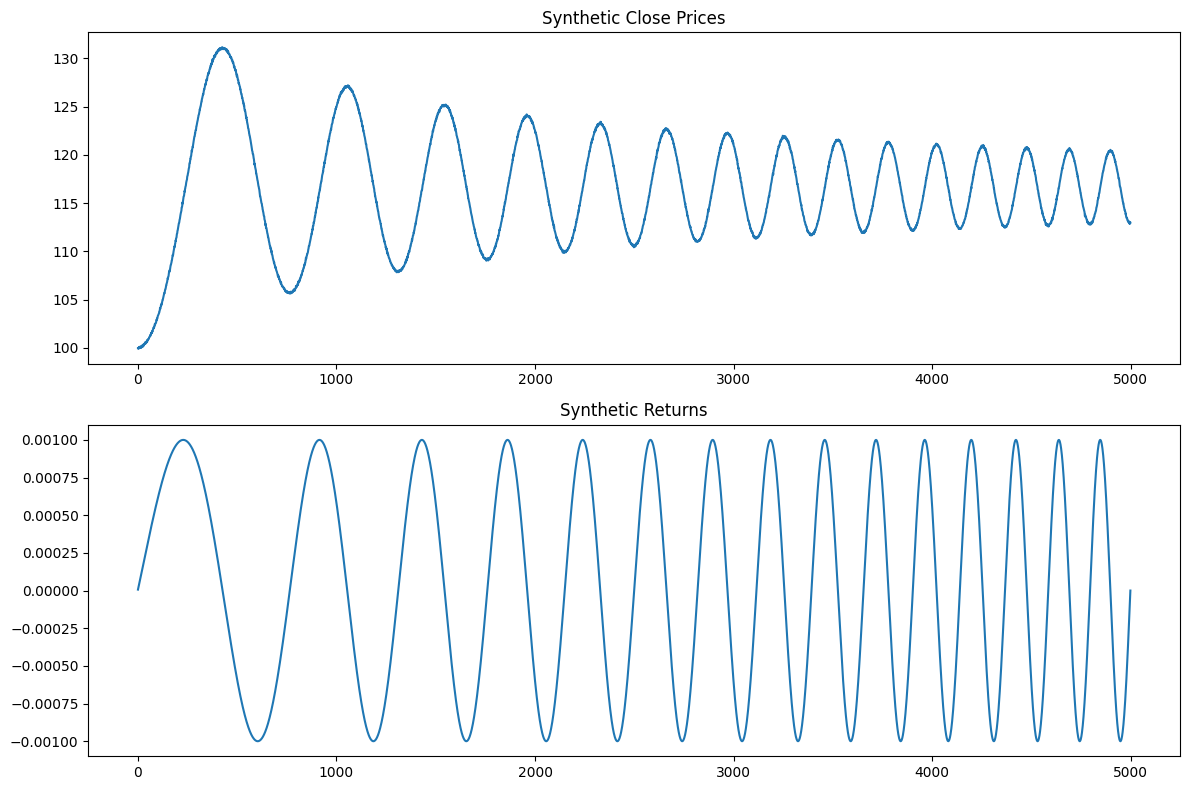

In [34]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization

def generate_synthetic_market_data(
    n_steps=1000,
    base_volatility=0.01,
    signal_strength=1.0,
    noise_strength=0.5,
    freq_range=(0.0005, 0.005),
    random_seed=None
):
    """
    Generate synthetic OHLCV + Returns data.
    
    Args:
        n_steps (int): Number of timesteps.
        base_volatility (float): Base volatility of returns.
        signal_strength (float): Scale of structured signal.
        noise_strength (float): Scale of noise added.
        freq_range (tuple): Min/max frequency for oscillations.
        random_seed (int): Random seed for reproducibility.
        
    Returns:
        pd.DataFrame: Dataframe with Open, High, Low, Close, Volume, Returns
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # Time array
    t = np.linspace(0, 1, n_steps)

    # Oscillatory signal with varying frequency
    freq = np.linspace(freq_range[0], freq_range[1], n_steps)
    phase = np.cumsum(freq) * 2 * np.pi
    structured_returns = np.sin(phase)

    # Normalize structured returns
    structured_returns = structured_returns / np.max(np.abs(structured_returns))

    # Add noise
    noise = np.random.normal(0, 1, n_steps)

    returns = signal_strength * structured_returns + noise_strength * noise

    # Scale to base volatility
    returns = returns * base_volatility

    # Create price series from returns
    price = 100 * np.exp(np.cumsum(returns))

    # Generate OHLCV
    open_prices = price
    close_prices = price * (1 + np.random.normal(0, 0.0005, n_steps))
    high_prices = np.maximum(open_prices, close_prices) * (1 + np.random.uniform(0.0001, 0.002, n_steps))
    low_prices = np.minimum(open_prices, close_prices) * (1 - np.random.uniform(0.0001, 0.002, n_steps))
    volumes = np.random.randint(100, 10000, size=n_steps)

    # Build DataFrame
    df = pd.DataFrame({
        'Open': open_prices,
        'High': high_prices,
        'Low': low_prices,
        'Close': close_prices,
        'Volume': volumes,
        'Returns': returns
    })

    return df

# Example usage
df = generate_synthetic_market_data(
    n_steps=5000,
    base_volatility=0.001,
    signal_strength=1,
    noise_strength=0,
    freq_range=(0.001, 0.005),
    random_seed=42
)

print(df.head())

# Plot to visualize (optional)
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(2, 1, figsize=(12,8))
    axs[0].plot(df['Close'])
    axs[0].set_title('Synthetic Close Prices')
    axs[1].plot(df['Returns'])
    axs[1].set_title('Synthetic Returns')
    plt.tight_layout()
    plt.show()

In [35]:
df.drop(columns=['Returns'], inplace=True)
df = data.train_test_split(df)
df = data.add_returns(df)
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,SPLIT,Return,Return_Target
0,100.000628,100.071667,99.871718,99.979440,4518,train,0.000013,0.000019
1,100.001885,100.031460,99.861035,99.979214,9496,train,0.000019,0.000025
2,100.003772,100.027416,99.900440,99.913986,2086,train,0.000025,0.000031
3,100.006288,100.034202,99.844664,99.989782,446,train,0.000031,0.000038
4,100.009434,100.166880,99.864066,100.046079,5925,train,0.000038,0.000044


In [36]:
# normalize all features but not targets
DF = df.copy()

numerical_columns = categorical_columns = "all"
exclude_columns = [] # ['Return_Target']
DF_features = ['Open', 'High', 'Low', 'Close', 'Volume']
DF, DF_columns = data.normalize_data(DF, exclude_columns=exclude_columns)

In [37]:
DF

,Open,High,Low,Close,Volume,SPLIT,Return,Return_Target
0,0.000000,0.001411,0.000867,0.002095,0.446308,train,0.506036,0.509182
1,0.000040,0.000129,0.000525,0.002088,0.949187,train,0.509182,0.512330
2,0.000101,0.000000,0.001788,0.000000,0.200626,train,0.512330,0.515481
3,0.000182,0.000216,0.000000,0.002427,0.034953,train,0.515481,0.518633
4,0.000283,0.004447,0.000622,0.004229,0.588443,train,0.518633,0.521787
...,...,...,...,...,...,...,...,...
4993,0.418282,0.417182,0.415302,0.416339,0.596929,test,0.421564,0.437102
4994,0.417714,0.422369,0.415884,0.420644,0.540358,test,0.437102,0.452706
4995,0.417259,0.422226,0.415836,0.420384,0.319931,test,0.452706,0.468358
4996,0.416917,0.417210,0.410734,0.414077,0.768360,test,0.468358,0.484045


In [38]:
import json
import optuna
from IPython.display import display, HTML
import joblib

importlib.reload(LSTM_returns)

Log = []

def objective(trial):
    entry = {}
    # Example of hyperparameter suggestions
    hyperparams = {
        'lstm_units': 70,
        'num_layers': trial.suggest_int('num_layers', 3, 5), # 1 to 5
        'epochs': 20,
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'dropout': 0.05,
        # 'dropout': trial.suggest_float('dropout_rate', 0.0, 0.5),
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]),
        # 'LSTM_activation': trial.suggest_categorical('lstm_activation', ['relu', 'tanh']),
        # 'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'activation': 'tanh',
        '__+ABD_exceptLast': trial.suggest_categorical('__+ABD_exceptLast', [True, False]),
        '__finalAct': trial.suggest_categorical('__finalAct', ['linear', 'sigmoid', 'tanh']),
        # '__penultRelu': trial.suggest_categorical('__penultRelu', [True, False]),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'rmsprop']),
        # 'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop']),
        # 'loss': trial.suggest_categorical('loss', ['mean_squared_error', 'mean_absolute_error', 'huber']),
    }
    episode_lengths = trial.suggest_int('episode_length', 10, 40)
    hyperparams['episode_length'] = episode_lengths
    hyperparams['layers'] = [hyperparams['lstm_units']] * hyperparams['num_layers']
    hyperparams['loss'] = 'mean_squared_error'
    

    train_X_y = LSTM_returns.vectorize_train_data(DF, features=DF_features, episode_length=episode_lengths)
    hyperparams['input_shape'] = train_X_y['train_X'].shape[1:]
    
    LSTM = LSTM_returns.create(hyperparams)
    results = LSTM_returns.train(LSTM, hyperparams, train_X_y, evaluateAtEnd=False)

    entry['hyperparams'] = hyperparams
    entry['results'] = results
    entry['plot-title'] = f"EL: {episode_lengths}; HP: {json.dumps(hyperparams)}"
    entry['model'] = LSTM
    entry['train_X_y'] = train_X_y
    Log.append(entry)

    return results.history['loss'][-1]  # Return the last loss value as the score


# Example Optuna study
study = optuna.create_study(direction='minimize')  # or 'maximize' depending on the objective

for i in range(50):
    study.optimize(objective, n_trials=1)

    # best_entry = [
    #     entry for entry in Log if entry['results'].history['loss'][-1] == study.best_value
    # ][-1]

    latest_entry = Log[-1]
    Log = []

    # Print the best hyperparameters
    # Display the best hyperparameters and score in purple
    display(HTML(f"""
    <div style="color: purple; background: orange; font-weight: bold;">
        Trial {i*10+1} completed.<br>
        Best hyperparameters: {study.best_params}<br>
        Best score (MSE): {study.best_value}<br>
    </div>
    """))

    # Display the best entry plot
    plt = LSTM_returns.all_folds_plot(
        latest_entry['model'], latest_entry['train_X_y']
    )
    plt.title(latest_entry['plot-title'][:175])
    print(latest_entry['plot-title'])
    plt.savefig(f"trials-synthetic/{i*10:05}.png", dpi=150, bbox_inches='tight')
    plt.close()


[I 2025-04-26 18:52:25,122] A new study created in memory with name: no-name-5b80d77a-7d07-45ee-a7b3-26023b04c892


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0915 - mae: 0.2319
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0224 - mae: 0.1115
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0139 - mae: 0.0891
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0121 - mae: 0.0817
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0124 - mae: 0.0831
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0072 - mae: 0.0630
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0099 - mae: 0.0728
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0089 - mae: 0.0690
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0102 - mae: 0.0730
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0062 - mae: 0.0572
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0069 - mae: 0.0615
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0057 - mae: 0.0552
Epoch 13/20
249/249 ━━━━

[I 2025-04-26 18:53:55,816] Trial 0 finished with value: 0.003823863575235009 and parameters: {'num_layers': 5, 'batch_size': 16, 'learning_rate': 0.001, '__+ABD_exceptLast': True, '__finalAct': 'tanh', 'optimizer': 'adam', 'episode_length': 31}. Best is trial 0 with value: 0.003823863575235009.


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
EL: 31; HP: {"lstm_units": 70, "num_layers": 5, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "tanh", "optimizer": "adam", "episode_length": 31, "layers": [70, 70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [31, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1770 - mae: 0.3305
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0662 - mae: 0.1965
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0502 - mae: 0.1603
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0318 - mae: 0.1289
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0248 - mae: 0.1138
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0285 - mae: 0.1136
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0163 - mae: 0.0927
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0129 - mae: 0.0839
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0192 - mae: 0.0930
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0165 - mae: 0.0901
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0131 - mae: 0.0829
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0109 - mae: 0.0705
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/s

[I 2025-04-26 18:54:30,985] Trial 1 finished with value: 0.004410686437040567 and parameters: {'num_layers': 4, 'batch_size': 64, 'learning_rate': 0.1, '__+ABD_exceptLast': True, '__finalAct': 'tanh', 'optimizer': 'rmsprop', 'episode_length': 31}. Best is trial 0 with value: 0.003823863575235009.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
EL: 31; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "tanh", "optimizer": "rmsprop", "episode_length": 31, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [31, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1361 - mae: 0.3208
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0629 - mae: 0.2065
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0236 - mae: 0.1149
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0207 - mae: 0.0994
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0142 - mae: 0.0865
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0123 - mae: 0.0808
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0100 - mae: 0.0702
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0091 - mae: 0.0668
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0074 - mae: 0.0602
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0067 - mae: 0.0585
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0060 - mae: 0.0566
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0054 - mae: 0.0513
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━

[I 2025-04-26 18:55:19,817] Trial 2 finished with value: 0.002498767338693142 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'tanh', 'optimizer': 'rmsprop', 'episode_length': 31}. Best is trial 2 with value: 0.002498767338693142.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 31; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "tanh", "optimizer": "rmsprop", "episode_length": 31, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [31, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.1114 - mae: 0.2958
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0838 - mae: 0.2486
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0348 - mae: 0.1448
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0218 - mae: 0.1063
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0161 - mae: 0.0903
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0127 - mae: 0.0803
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0107 - mae: 0.0745
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0124 - mae: 0.0751
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0098 - mae: 0.0700
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0069 - mae: 0.0586
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0074 - mae: 0.0624
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0073 - mae: 0.0601
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 18:56:23,626] Trial 3 finished with value: 0.004001525230705738 and parameters: {'num_layers': 5, 'batch_size': 32, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'rmsprop', 'episode_length': 40}. Best is trial 2 with value: 0.002498767338693142.


124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
EL: 40; HP: {"lstm_units": 70, "num_layers": 5, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "rmsprop", "episode_length": 40, "layers": [70, 70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [40, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1518 - mae: 0.3337
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0997 - mae: 0.2731
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0600 - mae: 0.2034
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0295 - mae: 0.1345
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0230 - mae: 0.1181
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0184 - mae: 0.1064
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0171 - mae: 0.0974
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0138 - mae: 0.0844
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0124 - mae: 0.0791
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0109 - mae: 0.0767
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0093 - mae: 0.0717
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0093 - mae: 0.0710
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 18:57:11,288] Trial 4 finished with value: 0.004912652540951967 and parameters: {'num_layers': 5, 'batch_size': 32, 'learning_rate': 0.0001, '__+ABD_exceptLast': False, '__finalAct': 'linear', 'optimizer': 'rmsprop', 'episode_length': 33}. Best is trial 2 with value: 0.002498767338693142.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
EL: 33; HP: {"lstm_units": 70, "num_layers": 5, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.0001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "linear", "optimizer": "rmsprop", "episode_length": 33, "layers": [70, 70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [33, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1489 - mae: 0.3337
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1000 - mae: 0.2727
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0591 - mae: 0.2020
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0289 - mae: 0.1305
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0232 - mae: 0.1137
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0194 - mae: 0.1053
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0151 - mae: 0.0917
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0155 - mae: 0.0917
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0128 - mae: 0.0846
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0129 - mae: 0.0803
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0100 - mae: 0.0729
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0095 - mae: 0.0709
Epoch 13/20
125/125 ━━━━

[I 2025-04-26 18:57:41,450] Trial 5 finished with value: 0.004715874791145325 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'linear', 'optimizer': 'rmsprop', 'episode_length': 27}. Best is trial 2 with value: 0.002498767338693142.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 27; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "linear", "optimizer": "rmsprop", "episode_length": 27, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [27, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0843 - mae: 0.2124
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0142 - mae: 0.0909
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0157 - mae: 0.0952
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0080 - mae: 0.0683
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0065 - mae: 0.0620
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0061 - mae: 0.0595
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0079 - mae: 0.0660
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0068 - mae: 0.0608
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0071 - mae: 0.0640
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0051 - mae: 0.0539
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0054 - mae: 0.0545
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0053 - mae: 0.0550
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 18:58:36,145] Trial 6 finished with value: 0.003873973386362195 and parameters: {'num_layers': 4, 'batch_size': 32, 'learning_rate': 0.1, '__+ABD_exceptLast': True, '__finalAct': 'linear', 'optimizer': 'adam', 'episode_length': 35}. Best is trial 2 with value: 0.002498767338693142.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
EL: 35; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "linear", "optimizer": "adam", "episode_length": 35, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [35, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.1287 - mae: 0.2859
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0361 - mae: 0.1384
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0221 - mae: 0.1067
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0171 - mae: 0.0946
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0170 - mae: 0.0896
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0130 - mae: 0.0810
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0133 - mae: 0.0797
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0104 - mae: 0.0744
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0092 - mae: 0.0693
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0077 - mae: 0.0606
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0067 - mae: 0.0606
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0065 - mae: 0.0583
Epoch 13/20
125/125 ━━━━

[I 2025-04-26 18:59:34,042] Trial 7 finished with value: 0.004968950059264898 and parameters: {'num_layers': 5, 'batch_size': 32, 'learning_rate': 0.001, '__+ABD_exceptLast': True, '__finalAct': 'tanh', 'optimizer': 'rmsprop', 'episode_length': 29}. Best is trial 2 with value: 0.002498767338693142.


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
EL: 29; HP: {"lstm_units": 70, "num_layers": 5, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "tanh", "optimizer": "rmsprop", "episode_length": 29, "layers": [70, 70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [29, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1679 - mae: 0.3506
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1236 - mae: 0.3110
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1231 - mae: 0.3113
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1214 - mae: 0.3105
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1213 - mae: 0.3115
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1213 - mae: 0.3105
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1199 - mae: 0.3095
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1178 - mae: 0.3040
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1169 - mae: 0.3041
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1132 - mae: 0.3009
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1068 - mae: 0.2896
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0959 - mae: 0.2713
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/s

[I 2025-04-26 18:59:59,296] Trial 8 finished with value: 0.02876661717891693 and parameters: {'num_layers': 5, 'batch_size': 64, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'linear', 'optimizer': 'rmsprop', 'episode_length': 16}. Best is trial 2 with value: 0.002498767338693142.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 16; HP: {"lstm_units": 70, "num_layers": 5, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "linear", "optimizer": "rmsprop", "episode_length": 16, "layers": [70, 70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [16, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1468 - mae: 0.3320
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0861 - mae: 0.2483
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0503 - mae: 0.1838
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0266 - mae: 0.1280
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0240 - mae: 0.1157
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0170 - mae: 0.0969
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0136 - mae: 0.0809
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0109 - mae: 0.0756
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0111 - mae: 0.0756
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0092 - mae: 0.0669
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0085 - mae: 0.0676
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0068 - mae: 0.0591
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 19:00:52,736] Trial 9 finished with value: 0.0038198481779545546 and parameters: {'num_layers': 4, 'batch_size': 32, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'tanh', 'optimizer': 'rmsprop', 'episode_length': 38}. Best is trial 2 with value: 0.002498767338693142.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
EL: 38; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "tanh", "optimizer": "rmsprop", "episode_length": 38, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [38, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1222 - mae: 0.3133
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1111 - mae: 0.2949
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0433 - mae: 0.1602
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0053 - mae: 0.0536
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0034 - mae: 0.0439
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0024 - mae: 0.0371
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0025 - mae: 0.0368
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0044 - mae: 0.0473
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0023 - mae: 0.0360
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0020 - mae: 0.0329
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0032 - mae: 0.0421
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0028 - mae: 0.0384
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━

[I 2025-04-26 19:01:29,656] Trial 10 finished with value: 0.0011699068127200007 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 20}. Best is trial 10 with value: 0.0011699068127200007.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 20; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 20, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [20, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1223 - mae: 0.3134
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1120 - mae: 0.2967
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0337 - mae: 0.1390
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0074 - mae: 0.0611
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0037 - mae: 0.0450
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0040 - mae: 0.0446
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0055 - mae: 0.0516
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0034 - mae: 0.0418
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0029 - mae: 0.0382
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0024 - mae: 0.0346
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0018 - mae: 0.0311
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0030 - mae: 0.0393
Epoch 13/20
249/249 ━━━━━

[I 2025-04-26 19:02:05,899] Trial 11 finished with value: 0.004079652484506369 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 20}. Best is trial 10 with value: 0.0011699068127200007.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 20; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 20, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [20, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1264 - mae: 0.3192
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1241 - mae: 0.3145
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1218 - mae: 0.3132
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1218 - mae: 0.3121
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1195 - mae: 0.3082
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1178 - mae: 0.3082
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0802 - mae: 0.2384
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0106 - mae: 0.0726
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0094 - mae: 0.0674
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0057 - mae: 0.0540
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0044 - mae: 0.0494
Epoch 12/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0043 - mae: 0.0473
Epoch 13/20
250/250 ━━━━━━━━━━━━━━━━

[I 2025-04-26 19:02:29,105] Trial 12 finished with value: 0.004468944389373064 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 10}. Best is trial 10 with value: 0.0011699068127200007.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
EL: 10; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 10, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [10, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1223 - mae: 0.3133
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0875 - mae: 0.2510
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0079 - mae: 0.0660
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0039 - mae: 0.0482
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0026 - mae: 0.0389
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0626
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0018 - mae: 0.0322
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0025 - mae: 0.0373
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0035 - mae: 0.0403
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0020 - mae: 0.0329
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0056 - mae: 0.0508
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0013 - mae: 0.0263
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━

[I 2025-04-26 19:03:12,211] Trial 13 finished with value: 0.0009966789511963725 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 23}. Best is trial 13 with value: 0.0009966789511963725.


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
EL: 23; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 23, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [23, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1240 - mae: 0.3143
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1163 - mae: 0.3041
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0923 - mae: 0.2590
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0064 - mae: 0.0585
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0040 - mae: 0.0465
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0044 - mae: 0.0477
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0029 - mae: 0.0397
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0031 - mae: 0.0396
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0026 - mae: 0.0375
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0024 - mae: 0.0360
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0012 - mae: 0.0271
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0023 - mae: 0.0346
Epoch 13/20
249/249 ━━━━━━━━━━

[I 2025-04-26 19:04:06,473] Trial 14 finished with value: 0.0005576040130108595 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 21}. Best is trial 14 with value: 0.0005576040130108595.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
EL: 21; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 21, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [21, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1202 - mae: 0.3095
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1078 - mae: 0.2893
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0361 - mae: 0.1446
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0060 - mae: 0.0589
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0025 - mae: 0.0390
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0024 - mae: 0.0357
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0031 - mae: 0.0404
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0031 - mae: 0.0408
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0017 - mae: 0.0311
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0025 - mae: 0.0359
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0033 - mae: 0.0410
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0014 - mae: 0.0284
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━

[I 2025-04-26 19:04:45,892] Trial 15 finished with value: 0.0008685520151630044 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 21}. Best is trial 14 with value: 0.0005576040130108595.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 21; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 21, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [21, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1252 - mae: 0.3182
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1211 - mae: 0.3101
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1196 - mae: 0.3082
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1190 - mae: 0.3071
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1178 - mae: 0.3068
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1167 - mae: 0.3044
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1130 - mae: 0.2944
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0125 - mae: 0.0806
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0078 - mae: 0.0626
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0070 - mae: 0.0612
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0033 - mae: 0.0427
Epoch 12/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0055 - mae: 0.0529
Epoch 13/20
250/250 ━━━━━━━━━━━━━

[I 2025-04-26 19:05:33,562] Trial 16 finished with value: 0.0022634954657405615 and parameters: {'num_layers': 4, 'batch_size': 16, 'learning_rate': 0.0001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 14}. Best is trial 14 with value: 0.0005576040130108595.


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
EL: 14; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.0001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 14, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [14, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1236 - mae: 0.3149
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0914 - mae: 0.2581
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0065 - mae: 0.0619
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0055 - mae: 0.0555
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0039 - mae: 0.0448
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0025 - mae: 0.0374
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0020 - mae: 0.0337
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0039 - mae: 0.0440
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0012 - mae: 0.0270
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011 - mae: 0.0247
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0029 - mae: 0.0392
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015 - mae: 0.0290
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━

[I 2025-04-26 19:06:25,652] Trial 17 finished with value: 0.0005381484515964985 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 23}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 23; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 23, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [23, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0868 - mae: 0.2481
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0293 - mae: 0.1204
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0101 - mae: 0.0714
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0125 - mae: 0.0815
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0074 - mae: 0.0631
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0083 - mae: 0.0656
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0089 - mae: 0.0670
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0077 - mae: 0.0628
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0068 - mae: 0.0619
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0073 - mae: 0.0616
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0060 - mae: 0.0551
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0042 - mae: 0.0484
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/s

[I 2025-04-26 19:06:57,211] Trial 18 finished with value: 0.004875503480434418 and parameters: {'num_layers': 4, 'batch_size': 64, 'learning_rate': 1e-05, '__+ABD_exceptLast': True, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 25}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 25; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 25, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [25, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1243 - mae: 0.3161
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1195 - mae: 0.3067
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1168 - mae: 0.3031
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0436 - mae: 0.1609
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0082 - mae: 0.0654
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - mae: 0.0422
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0113 - mae: 0.0717
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0065 - mae: 0.0535
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0211 - mae: 0.0956
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - mae: 0.0369
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - mae: 0.0472
Epoch 12/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - mae: 0.0500
Epoch 13/20
250/250 ━━━━━━━━━━━━━━━━

[I 2025-04-26 19:07:29,472] Trial 19 finished with value: 0.002754660090431571 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 16}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
EL: 16; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 16, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [16, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1202 - mae: 0.3093
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0918 - mae: 0.2614
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0080 - mae: 0.0649
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0041 - mae: 0.0471
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0026 - mae: 0.0384
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0028 - mae: 0.0389
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0027 - mae: 0.0369
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0020 - mae: 0.0320
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0024 - mae: 0.0356
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0013 - mae: 0.0280
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0035 - mae: 0.0426
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0024 - mae: 0.0350
Epoch 13/20
249/249 ━━━━━━━━━━━━

[I 2025-04-26 19:08:22,798] Trial 20 finished with value: 0.0010176680516451597 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.0001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 25}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 25; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.0001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 25, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [25, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1211 - mae: 0.3097
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1120 - mae: 0.2966
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0337 - mae: 0.1303
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0048 - mae: 0.0508
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0038 - mae: 0.0436
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0029 - mae: 0.0392
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0040 - mae: 0.0448
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0019 - mae: 0.0321
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0032 - mae: 0.0407
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0023 - mae: 0.0349
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0024 - mae: 0.0357
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011 - mae: 0.0249
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━

[I 2025-04-26 19:09:02,458] Trial 21 finished with value: 0.0013286970788612962 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 21}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 21; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 21, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [21, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1241 - mae: 0.3154
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1180 - mae: 0.3063
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0558 - mae: 0.1868
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0053 - mae: 0.0533
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0043 - mae: 0.0483
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0026 - mae: 0.0381
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0058 - mae: 0.0539
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0023 - mae: 0.0359
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0022 - mae: 0.0353
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0032 - mae: 0.0410
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0018 - mae: 0.0315
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0029 - mae: 0.0393
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━

[I 2025-04-26 19:10:06,149] Trial 22 finished with value: 0.0010337377898395061 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 18}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
EL: 18; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 18, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [18, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1211 - mae: 0.3098
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1107 - mae: 0.2947
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0187 - mae: 0.0955
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0051 - mae: 0.0527
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0084 - mae: 0.0633
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0019 - mae: 0.0336
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0028 - mae: 0.0390
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0021 - mae: 0.0347
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0013 - mae: 0.0270
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0029 - mae: 0.0382
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0020 - mae: 0.0328
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0016 - mae: 0.0293
Epoch 13/20
249/249 ━━━━

[I 2025-04-26 19:11:00,194] Trial 23 finished with value: 0.0011146583128720522 and parameters: {'num_layers': 4, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 23}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 23; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 23, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [23, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1243 - mae: 0.3153
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1192 - mae: 0.3077
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1213 - mae: 0.3121
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1188 - mae: 0.3075
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1144 - mae: 0.3027
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0181 - mae: 0.0969
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0125 - mae: 0.0804
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0061 - mae: 0.0553
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045 - mae: 0.0491
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029 - mae: 0.0402
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035 - mae: 0.0436
Epoch 12/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039 - mae: 0.0448
Epoch 13/20
250/250 ━━━━━━━━━━━━━━━━

[I 2025-04-26 19:11:29,125] Trial 24 finished with value: 0.004123875871300697 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 13}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
EL: 13; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 13, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [13, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1210 - mae: 0.3107
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1117 - mae: 0.2960
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0986 - mae: 0.2782
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0517 - mae: 0.1900
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0114 - mae: 0.0807
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - mae: 0.0469
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0385
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0018 - mae: 0.0349
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020 - mae: 0.0357
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - mae: 0.0303
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - mae: 0.0260
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0107 - mae: 0.0726
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/s

[I 2025-04-26 19:11:47,655] Trial 25 finished with value: 0.001647989614866674 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 22}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 22; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 22, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [22, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0639 - mae: 0.2000
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0142 - mae: 0.0862
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0119 - mae: 0.0795
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0095 - mae: 0.0724
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0068 - mae: 0.0613
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0082 - mae: 0.0656
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0086 - mae: 0.0661
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0065 - mae: 0.0592
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0068 - mae: 0.0592
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0052 - mae: 0.0527
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0051 - mae: 0.0524
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0062 - mae: 0.0565
Epoch 13/20
249/249 ━━━━━━━━━━━━━

[I 2025-04-26 19:12:38,813] Trial 26 finished with value: 0.0026203952729701996 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.1, '__+ABD_exceptLast': True, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 27}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 27; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 27, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [27, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1238 - mae: 0.3158
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1177 - mae: 0.3062
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1095 - mae: 0.2924
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0203 - mae: 0.1003
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0659
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0029 - mae: 0.0410
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0027 - mae: 0.0388
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0018 - mae: 0.0324
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0021 - mae: 0.0339
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0018 - mae: 0.0309
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0018 - mae: 0.0313
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0026 - mae: 0.0344
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━

[I 2025-04-26 19:13:22,439] Trial 27 finished with value: 0.0016201261896640062 and parameters: {'num_layers': 4, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 18}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 18; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 18, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [18, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1489 - mae: 0.3345
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1198 - mae: 0.3079
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0996 - mae: 0.2750
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0256 - mae: 0.1178
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0067 - mae: 0.0635
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0021 - mae: 0.0354
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0022 - mae: 0.0357
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0032 - mae: 0.0436
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0019 - mae: 0.0334
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0027 - mae: 0.0404
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0032 - mae: 0.0433
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0025 - mae: 0.0373
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━

[I 2025-04-26 19:14:24,207] Trial 28 finished with value: 0.0014824694953858852 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'linear', 'optimizer': 'adam', 'episode_length': 18}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
EL: 18; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "linear", "optimizer": "adam", "episode_length": 18, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [18, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0737 - mae: 0.2179
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0161 - mae: 0.0952
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0218 - mae: 0.1054
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0118 - mae: 0.0795
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0075 - mae: 0.0638
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0079 - mae: 0.0648
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0079 - mae: 0.0657
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0071 - mae: 0.0621
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0061 - mae: 0.0574
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0064 - mae: 0.0585
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0052 - mae: 0.0531
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0044 - mae: 0.0495
Epoch 13/20
249/249 ━━━━

[I 2025-04-26 19:15:33,557] Trial 29 finished with value: 0.0039560371078550816 and parameters: {'num_layers': 4, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': True, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 25}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 25; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 25, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [25, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1612 - mae: 0.3462
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1165 - mae: 0.3015
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0940 - mae: 0.2667
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0703 - mae: 0.2247
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0318 - mae: 0.1474
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0260 - mae: 0.1228
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042 - mae: 0.0515
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0027 - mae: 0.0415
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0028 - mae: 0.0410
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - mae: 0.0348
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - mae: 0.0316
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016 - mae: 0.0310
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/s

[I 2025-04-26 19:15:57,186] Trial 30 finished with value: 0.001199420541524887 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'tanh', 'optimizer': 'adam', 'episode_length': 28}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 28; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "tanh", "optimizer": "adam", "episode_length": 28, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [28, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1222 - mae: 0.3133
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0998 - mae: 0.2754
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0132 - mae: 0.0800
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0041 - mae: 0.0480
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0024 - mae: 0.0375
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0043 - mae: 0.0469
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015 - mae: 0.0299
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0019 - mae: 0.0316
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0024 - mae: 0.0344
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0025 - mae: 0.0340
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.2679e-04 - mae: 0.0207
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0017 - mae: 0.0292
Epoch 13/20
249/249 ━━━━━━━━━━━━

[I 2025-04-26 19:16:37,730] Trial 31 finished with value: 0.0007124780677258968 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 23}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 23; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 23, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [23, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1187 - mae: 0.3084
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0803 - mae: 0.2400
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0070 - mae: 0.0616
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0045 - mae: 0.0489
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0020 - mae: 0.0352
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0019 - mae: 0.0330
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0034 - mae: 0.0425
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0018 - mae: 0.0317
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0021 - mae: 0.0323
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0025 - mae: 0.0365
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0012 - mae: 0.0263
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0015 - mae: 0.0283
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━

[I 2025-04-26 19:17:19,450] Trial 32 finished with value: 0.0007329091313295066 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 24}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 24; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 24, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [24, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1215 - mae: 0.3104
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1123 - mae: 0.2967
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0483 - mae: 0.1711
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0059 - mae: 0.0576
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0050 - mae: 0.0524
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0022 - mae: 0.0361
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0016 - mae: 0.0309
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0013 - mae: 0.0267
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0026 - mae: 0.0348
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0013 - mae: 0.0270
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0019 - mae: 0.0317
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0012 - mae: 0.0260
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━

[I 2025-04-26 19:18:00,915] Trial 33 finished with value: 0.0010393582051619887 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 24}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 24; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 24, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [24, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1167 - mae: 0.3041
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0663 - mae: 0.2075
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0045 - mae: 0.0502
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0031 - mae: 0.0411
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0026 - mae: 0.0361
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0026 - mae: 0.0370
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0019 - mae: 0.0312
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0024 - mae: 0.0357
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0017 - mae: 0.0292
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0020 - mae: 0.0319
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0018 - mae: 0.0303
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - mae: 0.0262
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━

[I 2025-04-26 19:18:47,841] Trial 34 finished with value: 0.0006880990695208311 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 29}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 29; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 29, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [29, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1343 - mae: 0.3141
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0374 - mae: 0.1542
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0061 - mae: 0.0586
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0066 - mae: 0.0583
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0020 - mae: 0.0345
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0020 - mae: 0.0338
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0018 - mae: 0.0300
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0026 - mae: 0.0369
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0012 - mae: 0.0261
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0018 - mae: 0.0314
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011 - mae: 0.0245
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0026 - mae: 0.0363
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━

[I 2025-04-26 19:19:38,409] Trial 35 finished with value: 0.0009151498088613153 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'tanh', 'optimizer': 'adam', 'episode_length': 31}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 31; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "tanh", "optimizer": "adam", "episode_length": 31, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [31, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0605 - mae: 0.1935
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0123 - mae: 0.0817
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0076 - mae: 0.0641
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0109 - mae: 0.0725
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0149 - mae: 0.0858
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0054 - mae: 0.0549
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0051 - mae: 0.0534
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0055 - mae: 0.0548
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0052 - mae: 0.0521
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0040 - mae: 0.0470
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0039 - mae: 0.0455
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0035 - mae: 0.0437
Epoch 13/20
249/249 ━━━━

[I 2025-04-26 19:20:34,117] Trial 36 finished with value: 0.00299470336176455 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.0001, '__+ABD_exceptLast': True, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 30}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 30; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.0001, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 30, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [30, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1673 - mae: 0.3517
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1239 - mae: 0.3088
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1097 - mae: 0.2909
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0991 - mae: 0.2735
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0756 - mae: 0.2334
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0539 - mae: 0.1894
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0455 - mae: 0.1671
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0305 - mae: 0.1343
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0264 - mae: 0.1248
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0248 - mae: 0.1199
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0240 - mae: 0.1153
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0212 - mae: 0.1087
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/s

[I 2025-04-26 19:21:02,207] Trial 37 finished with value: 0.011486628092825413 and parameters: {'num_layers': 4, 'batch_size': 64, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'linear', 'optimizer': 'rmsprop', 'episode_length': 27}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 27; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "linear", "optimizer": "rmsprop", "episode_length": 27, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [27, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1142 - mae: 0.2986
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0520 - mae: 0.1781
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0043 - mae: 0.0501
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0030 - mae: 0.0419
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0022 - mae: 0.0360
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0089 - mae: 0.0648
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0020 - mae: 0.0335
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0010 - mae: 0.0243
Epoch 9/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0012 - mae: 0.0258
Epoch 10/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0014 - mae: 0.0275
Epoch 11/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0014 - mae: 0.0265
Epoch 12/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0051 - mae: 0.0492
Epoch 13/20
248/248 ━━━━

[I 2025-04-26 19:21:58,311] Trial 38 finished with value: 0.0006857760017737746 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 34}. Best is trial 17 with value: 0.0005381484515964985.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 34; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 34, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [34, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1230 - mae: 0.2693
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0349 - mae: 0.1373
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0198 - mae: 0.1049
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0147 - mae: 0.0874
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0114 - mae: 0.0779
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0101 - mae: 0.0747
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0097 - mae: 0.0732
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0078 - mae: 0.0636
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0077 - mae: 0.0631
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0071 - mae: 0.0616
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0059 - mae: 0.0564
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0057 - mae: 0.0555
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 19:22:40,285] Trial 39 finished with value: 0.0036800529342144728 and parameters: {'num_layers': 4, 'batch_size': 32, 'learning_rate': 0.1, '__+ABD_exceptLast': True, '__finalAct': 'tanh', 'optimizer': 'rmsprop', 'episode_length': 33}. Best is trial 17 with value: 0.0005381484515964985.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
EL: 33; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "tanh", "optimizer": "rmsprop", "episode_length": 33, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [33, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1304 - mae: 0.3104
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0269 - mae: 0.1256
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0062 - mae: 0.0602
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0026 - mae: 0.0403
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0031 - mae: 0.0433
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0023 - mae: 0.0363
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 9.2512e-04 - mae: 0.0234
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0011 - mae: 0.0249
Epoch 9/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0019 - mae: 0.0320
Epoch 10/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0036 - mae: 0.0443
Epoch 11/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 8.9455e-04 - mae: 0.0227
Epoch 12/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0017 - mae: 0.0302
Epoch 13/20

[I 2025-04-26 19:25:11,252] Trial 40 finished with value: 0.0016799394506961107 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'linear', 'optimizer': 'adam', 'episode_length': 36}. Best is trial 17 with value: 0.0005381484515964985.


124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


EL: 36; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "linear", "optimizer": "adam", "episode_length": 36, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [36, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.1163 - mae: 0.3044
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0210 - mae: 0.1090
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0071 - mae: 0.0618
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0038 - mae: 0.0453
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0019 - mae: 0.0334
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.0018 - mae: 0.0323
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0034 - mae: 0.0418
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0025 - mae: 0.0368
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0029 - mae: 0.0391
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0014 - mae: 0.0277
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0026 - mae: 0.0371
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0014 - mae: 0.0278
Epoch 13/20
249/24

[I 2025-04-26 19:27:41,481] Trial 41 finished with value: 0.0027450830675661564 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 32}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 32; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 32, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [32, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1156 - mae: 0.3012
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0493 - mae: 0.1742
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0041 - mae: 0.0486
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0044 - mae: 0.0481
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0021 - mae: 0.0351
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0018 - mae: 0.0327
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0059 - mae: 0.0529
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0034 - mae: 0.0398
Epoch 9/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0013 - mae: 0.0259
Epoch 10/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0021 - mae: 0.0329
Epoch 11/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.7973e-04 - mae: 0.0215
Epoch 12/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.8416e-04 - mae: 0.0192
Epoch 13/20
248/

[I 2025-04-26 19:28:38,593] Trial 42 finished with value: 0.000989170977845788 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 35}. Best is trial 17 with value: 0.0005381484515964985.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 35; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 35, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [35, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1160 - mae: 0.3011
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0959 - mae: 0.2660
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0267 - mae: 0.1217
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0030 - mae: 0.0418
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0052 - mae: 0.0523
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0020 - mae: 0.0315
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0022 - mae: 0.0344
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0010 - mae: 0.0234
Epoch 9/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0013 - mae: 0.0265
Epoch 10/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0010 - mae: 0.0230
Epoch 11/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0017 - mae: 0.0291
Epoch 12/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0012 - mae: 0.0241
Epoch 13/20
248/248 ━━━━

[I 2025-04-26 19:29:39,778] Trial 43 finished with value: 0.0009598506730981171 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 38}. Best is trial 17 with value: 0.0005381484515964985.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 38; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 38, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [38, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1210 - mae: 0.3117
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1001 - mae: 0.2794
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0582 - mae: 0.2012
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0277 - mae: 0.1216
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0174 - mae: 0.0956
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0157 - mae: 0.0929
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0145 - mae: 0.0868
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0121 - mae: 0.0782
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0093 - mae: 0.0691
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0098 - mae: 0.0658
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0108 - mae: 0.0680
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0083 - mae: 0.0620
Epoch 13/20
125/125 ━━━━

[I 2025-04-26 19:30:14,052] Trial 44 finished with value: 0.004540908616036177 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'rmsprop', 'episode_length': 29}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 29; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "rmsprop", "episode_length": 29, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [29, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1185 - mae: 0.3057
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1094 - mae: 0.2881
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1131 - mae: 0.2973
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0979 - mae: 0.2733
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0949 - mae: 0.2657
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0776 - mae: 0.2352
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0847 - mae: 0.2535
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0689 - mae: 0.2238
Epoch 9/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0133 - mae: 0.0867
Epoch 10/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0033 - mae: 0.0428
Epoch 11/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0019 - mae: 0.0332
Epoch 12/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0028 - mae: 0.0398
Epoch 13/20
248/248 ━━━━

[I 2025-04-26 19:31:19,122] Trial 45 finished with value: 0.0010931650176644325 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 40}. Best is trial 17 with value: 0.0005381484515964985.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
EL: 40; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 40, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [40, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1229 - mae: 0.3135
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1149 - mae: 0.3022
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1141 - mae: 0.3010
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1155 - mae: 0.3043
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1155 - mae: 0.3035
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1128 - mae: 0.2994
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1129 - mae: 0.2987
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1096 - mae: 0.2944
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1106 - mae: 0.2936
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1011 - mae: 0.2780
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0841 - mae: 0.2363
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0064 - mae: 0.0601
Epoch 13/20
2

[I 2025-04-26 19:32:18,606] Trial 46 finished with value: 0.0011851070448756218 and parameters: {'num_layers': 5, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'adam', 'episode_length': 20}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 20; HP: {"lstm_units": 70, "num_layers": 5, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 20, "layers": [70, 70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [20, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1363 - mae: 0.3272
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0923 - mae: 0.2606
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0249 - mae: 0.1215
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0029 - mae: 0.0418
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0033 - mae: 0.0424
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0029 - mae: 0.0396
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0023 - mae: 0.0360
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0022 - mae: 0.0354
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0058 - mae: 0.0476
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0019 - mae: 0.0332
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0016 - mae: 0.0298
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.4670e-04 - mae: 0.0237
Epoch 13/20
249/249 ━━━━━━━━━━━━

[I 2025-04-26 19:33:03,862] Trial 47 finished with value: 0.001395147992298007 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'tanh', 'optimizer': 'adam', 'episode_length': 26}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 26; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "tanh", "optimizer": "adam", "episode_length": 26, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [26, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1184 - mae: 0.3076
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0885 - mae: 0.2574
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0447 - mae: 0.1717
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0211 - mae: 0.1107
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0166 - mae: 0.0957
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0148 - mae: 0.0859
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0127 - mae: 0.0787
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0110 - mae: 0.0737
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0110 - mae: 0.0737
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0105 - mae: 0.0701
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0109 - mae: 0.0698
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0072 - mae: 0.0590
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 19:33:36,587] Trial 48 finished with value: 0.003927756566554308 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'optimizer': 'rmsprop', 'episode_length': 33}. Best is trial 17 with value: 0.0005381484515964985.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
EL: 33; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "rmsprop", "episode_length": 33, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [33, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1706 - mae: 0.3575
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1113 - mae: 0.2953
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0927 - mae: 0.2599
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0588 - mae: 0.1974
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0125 - mae: 0.0890
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0050 - mae: 0.0544
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0027 - mae: 0.0408
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0027 - mae: 0.0410
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034 - mae: 0.0467
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0024 - mae: 0.0392
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030 - mae: 0.0441
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - mae: 0.0315
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/s

[I 2025-04-26 19:34:00,333] Trial 49 finished with value: 0.0007038964540697634 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.0001, '__+ABD_exceptLast': False, '__finalAct': 'linear', 'optimizer': 'adam', 'episode_length': 29}. Best is trial 17 with value: 0.0005381484515964985.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 29; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.0001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "linear", "optimizer": "adam", "episode_length": 29, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [29, 5]}


c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py:180: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure the layout fits within the figure size


In [40]:
# Extract trial parameters and results
trials_data = [
    {**trial.params, 'value': trial.value, 'trial_number': trial.number}
    for trial in study.trials
]

# Convert to a DataFrame
trials_df = pd.DataFrame(trials_data)

# Display the DataFrame
trials_df.sort_values(by="value")

,num_layers,batch_size,learning_rate,__+ABD_exceptLast,__finalAct,optimizer,episode_length,value,trial_number
17,3,16,0.00001,False,sigmoid,adam,23,0.000538,17
14,3,16,0.00001,False,sigmoid,adam,21,0.000558,14
38,3,16,0.10000,False,sigmoid,adam,34,0.000686,38
34,3,16,0.00001,False,sigmoid,adam,29,0.000688,34
49,3,64,0.00010,False,linear,adam,29,0.000704,49
31,3,16,0.00001,False,sigmoid,adam,23,0.000712,31
32,3,16,0.00001,False,sigmoid,adam,24,0.000733,32
15,3,16,0.00001,False,sigmoid,adam,21,0.000869,15
35,3,16,0.00001,False,tanh,adam,31,0.000915,35
43,3,16,0.00100,False,sigmoid,adam,38,0.000960,43
